# Sparse Bundle Adjustment

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from time import time
from lib import misc, utils, app

plt.style.use(os.path.join('..', 'configs', 'mplstyle.yaml'))

%load_ext autoreload
%autoreload 2

ROOT_DATA_DIR = os.path.join("/Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main","data")

# Reconstruction Params
Define the params in the cell below. Thereafter, run all cells

In [2]:
DATA_DIR = os.path.join(ROOT_DATA_DIR, "2021_10_07", "Baboon1", "walk")

start_frame = 24320
end_frame = 24705

# DLC p_cutoff - any points with likelihood < dlc_thresh are not trusted in optimisation
dlc_thresh = 0.5 # change this only if the optimisation result is unsatisfactory

# Optimization

Initialization took 1.75 seconds

Loaded extrinsics from /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/extrinsic_calib/2_cam_scene_sba.json


bundle_adjust_points_only
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5297e+04                                    4.45e+01    
       1              2         1.5295e+04      1.69e+00       9.46e-02       3.22e-02    
       2              3         1.5295e+04      1.55e-05       1.12e-03       1.86e-02    
       3              4         1.5295e+04      2.68e-06       1.89e-04       1.02e-02    
       4              5         1.5295e+04      7.55e-07       1.17e-04       4.00e-02    
       5              6         1.5295e+04      1.96e-07       3.04e-05       4.15e-02    
       6              7         1.5295e+04      8.80e-08       6.07e-06       1.58e-02    
       7              8         1.5295e+04      1.46e-07       4.00e-05  

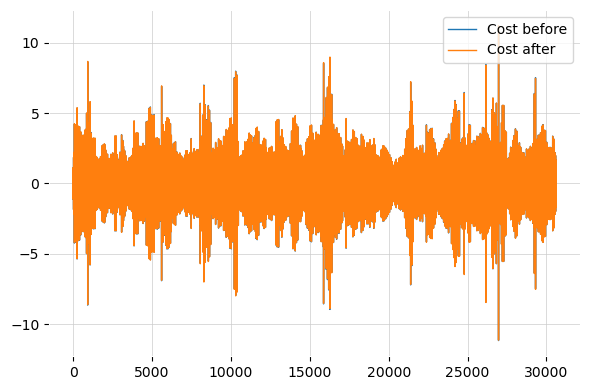

In [3]:
t0 = time()

assert os.path.exists(DATA_DIR)
OUT_DIR = os.path.join(DATA_DIR, 'sba')
DLC_DIR = os.path.join(DATA_DIR, 'dlc')
assert os.path.exists(DLC_DIR)
os.makedirs(OUT_DIR, exist_ok=True)

app.start_logging(os.path.join(OUT_DIR, 'sba.log'))

# load video info
res, fps, tot_frames, _ = app.get_vid_info(DATA_DIR) # path to original videos
assert end_frame <= tot_frames, f'end_frame must be less than or equal to {tot_frames}'

start_frame -= 1 # 0 based indexing
assert start_frame >= 0
N = end_frame-start_frame

*_, n_cams, scene_fpath = utils.find_scene_file(DATA_DIR, verbose=False)

dlc_points_fpaths = sorted(glob(os.path.join(DLC_DIR, '*.h5')))
assert n_cams == len(dlc_points_fpaths)
    
# Load Measurement Data (pixels, likelihood)
points_2d_df = utils.load_dlc_points_as_df(dlc_points_fpaths, verbose=False)
points_2d_df = points_2d_df[points_2d_df["frame"].between(start_frame, end_frame-1)]
points_2d_df = points_2d_df[points_2d_df['likelihood']>dlc_thresh] # ignore points with low likelihood

t1 = time()
print("Initialization took {0:.2f} seconds\n".format(t1 - t0))

points_3d_df, residuals = app.sba_points_fisheye(scene_fpath, points_2d_df)

app.stop_logging()

plt.plot(residuals['before'], label="Cost before")
plt.plot(residuals['after'], label="Cost after")
plt.legend()
fig_fpath = os.path.join(OUT_DIR, 'sba.svg')
plt.savefig(fig_fpath, transparent=True)
print(f'Saved {fig_fpath}\n')
plt.show(block=False)

# Save SBA results

In [4]:
markers = misc.get_markers()

positions = np.full((N, len(markers), 3), np.nan)
for i, marker in enumerate(markers):
    marker_pts = points_3d_df[points_3d_df["marker"]==marker][["frame", "x", "y", "z"]].values
    for frame, *pt_3d in marker_pts:
        positions[int(frame)-start_frame, i] = pt_3d

app.save_sba(positions, OUT_DIR, scene_fpath, start_frame, dlc_thresh)

Saved /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/Baboon1/walk/sba/sba.pickle
Saved /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/Baboon1/walk/sba/sba.mat
Saved /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/Baboon1/walk/sba/cam*_sba.h5
Saved /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/Baboon1/walk/sba/cam*_sba.csv

Saving labeled videos...


  0%|          | 2/25627 [00:00<25:21, 16.84it/s]

Loading cam2 and data.

Duration of video: 427.12 s, recorded with 60.0 fps!
Total frames: 25627 with frame dimensions: 1920 x 1080
Generating frames and creating video...
Loading cam1 and data.

Duration of video: 427.12 s, recorded with 60.0 fps!
Total frames: 25627 with frame dimensions: 1920 x 1080
Generating frames and creating video...


100%|██████████| 25627/25627 [09:13<00:00, 46.30it/s]

Done!



# Plot the baboon!

In [5]:
data_fpath = os.path.join(OUT_DIR, 'sba.pickle')
app.plot_baboon_reconstruction(data_fpath, reprojections=False, centered=True, dark_mode=True)

Loaded extrinsics from /Users/matthewterblanche/Downloads/Baboon Data/AcinoSet-main/data/2021_10_07/extrinsic_calib/2_cam_scene_sba.json



qt.qpa.window: <QNSWindow: 0x7ff16e13eef0; contentView=<QNSView: 0x7ff16e13e770; QCocoaWindow(0x7ff16e13e640, window=QWidgetWindow(0x7ff16e13e130, name="QGLWidgetClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
